In [19]:
import numpy as np
import pandas as pd
from math import log
import json

In [20]:
# Load reference datasets
countries  = pd.read_csv('../raw_data/CountriesList.txt', delimiter=' , ', index_col='Country Code')

latlong = pd.read_csv('../raw_data/LatLong.csv', index_col='Alpha-3',
                      usecols=['Alpha-3', 'lat', 'long'])

good_indices = (countries.index & latlong.index)

iso_codes = pd.read_csv('../raw_data/ISO_codes.csv', index_col='country-code')
def num_to_alpha3(num_code): return iso_codes.loc[num_code, 'alpha-3']

# Load population dataset
label_cols = ['Country Name', 'Country Code']
year_cols = ['1990', '1995', '2000', '2005', '2010', '2015']
keep_cols = label_cols + year_cols
pop = pd.read_csv('../raw_data/Population.csv',
                  index_col='Country Code', usecols=keep_cols)
pop = pop.reindex(pop.index & good_indices)

/home/ross/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  from ipykernel import kernelapp as app


In [21]:
bad_cols = ['Destination', 'Numeric', 'Data Type', 'Total', 'Other North', 'Other South']

def get_migrate_df(year):
    df = pd.read_excel('../raw_data/Migrate_'+year+'.xlsx', header=0)
    
    df = df.query('Numeric < 900 and Numeric != 830')
    df['Country Code'] = df['Numeric'].apply(num_to_alpha3)
    df.set_index('Country Code', inplace=True)
    df = df.reindex(df.index & pop[year].dropna().index)
    
    good_countries = set(df['Destination'])
    
    for ccol in df.columns[6:]:
        if ccol not in good_countries:
            df.drop(ccol, axis=1, inplace=True)
        else:
            df.rename(columns={ccol: df.index[df['Destination'] == ccol][0]}, inplace=True)
    
    return df.drop(bad_cols, axis=1)

In [22]:
immigrants = {}
emigrants = {}
maxs = {}

for year in year_cols:
    print("Getting im_ & em_ df's for: ", year)
    
    immigrants[year] = get_migrate_df(year)
    maxs[year] = immigrants[year].max().max()
    emigrants[year] = immigrants[year].transpose()
    
    print(immigrants[year].shape, emigrants[year].shape, immigrants[year].max().max())

Getting im_ & em_ df's for:  1990


/home/ross/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(168, 168) (168, 168) 5018098.0
Getting im_ & em_ df's for:  1995
(168, 168) (168, 168) 6602801.0
Getting im_ & em_ df's for:  2000
(168, 168) (168, 168) 9177487.0
Getting im_ & em_ df's for:  2005
(168, 168) (168, 168) 10309054.0
Getting im_ & em_ df's for:  2010
(168, 168) (168, 168) 11566960.0
Getting im_ & em_ df's for:  2015
(167, 167) (167, 167) 12050031.0


In [100]:
test = migrate['1995'].drop(bad_cols, axis=1)
from math import log
log(test.max().max(), 2)

22.6546467349417

In [45]:
class Scaler():
    def __init__(self, oldrange, newrange):
        self.oldmin = oldrange[0]
        self.oldrange = oldrange[1] - oldrange[0]
        self.newmin = newrange[0]
        self.newrange = newrange[1] - oldrange[0]
        
    def __call__(self, value):
        return (((value - self.oldmin)*self.newrange) / self.oldrange) + self.newmin

def single_arc(origin, destination, status, strokeWidth):
    d = {}
    d['origin'] = {'latitude': latlong.loc[origin]['lat'],
                   'longitude': latlong.loc[origin]['long']}
    d['destination'] = {'latitude': latlong.loc[destination]['lat'],
                        'longitude': latlong.loc[destination]['long']}
    d['strokeWidth'] = strokeWidth
    
    if status == 'im':
        d['strokeColor'] = 'green'
        d['id'] = origin
    elif status == 'em':
        d['strokeColor'] = 'red'
        d['id'] = destination
    
    return d

def row_arcs(row_name, row, status, scaler):
    if status == 'im':
        # for immigration, row_name = destination  
        l = [single_arc(origin, row_name, status, scaler(value)) for origin, value in row.items()]
    elif status == 'em':
        # for emigration, row_name = origin
        l = [single_arc(row_name, destination, status, scaler(value)) for destination, value in row.items()]
            
    return l

# threshold: we only count arcs where (num_people > threshold)
def df_arcs(df, status, threshold, maximum):
    assert status in ['im', 'em']
    # second parameter of Scaler sets the range for strokeWidth
    scaler = Scaler([0, maximum], [0.175, 8])
    d = {}
    if status == 'im':
        for code, row in df.iterrows():
            d[code] = row_arcs(code, row[row > threshold], 'im', scaler)
    elif status == 'em':
        for code, row in df.iterrows():
            d[code] = row_arcs(code, row[row > threshold], 'em', scaler)
    
    return d

In [46]:
im_arcs = {}
em_arcs = {}

for year in year_cols:
    # could also just pass absolute max instead of by year ?
    im_arcs[year] = df_arcs(immigrants[year], 'im', 1000, maxs[year])
    em_arcs[year] = df_arcs(emigrants[year], 'em', 1000, maxs[year])

In [44]:
with open('../processed_data/immigrant_arcs.json', 'w') as out:
    json.dump(im_arcs, out, indent=2)
    
with open('../processed_data/emigrant_arcs.json', 'w') as out:
    json.dump(em_arcs, out, indent=2)

In [8]:
test_scaler = Scaler([0,100], [0,10])
test_scaler(75)

7.5

## Create Net Migrant Stock dataset

In [37]:
positive_stock = pd.DataFrame(0.0, index=pop.index, columns=year_cols)
negative_stock = pd.DataFrame(0.0, index=pop.index, columns=year_cols)
net_stock = pd.DataFrame(0.0, index=pop.index, columns=year_cols)


for year in year_cols:
    positive_stock[year] = immigrants[year].fillna(0.0).sum(axis=0)
    negative_stock[year] = emigrants[year].fillna(0.0).sum(axis=0)
    net_stock[year] = positive_stock[year].apply(lambda x: x if x == 0 else log(x,2))\
                    - negative_stock[year].apply(lambda x: x if x == 0 else log(x,2))

print(net_stock.min().min(), net_stock.max().max())
net_stock.to_csv('../processed_data/LogNetMigrants.csv', index_label='id')

-6.3595662239 17.465773637


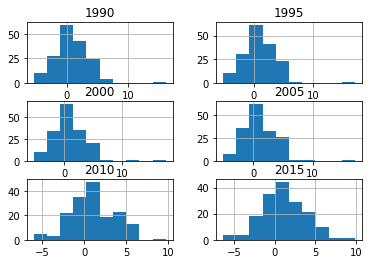

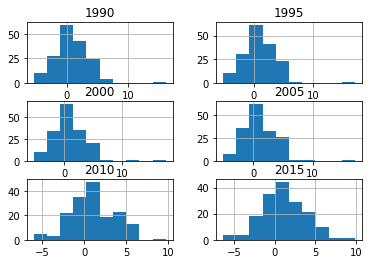

In [41]:
import matplotlib.pyplot as plt
net_stock.hist()
plt.show()

In [39]:
plt.show()

NameError: name 'plt' is not defined